# Speech Emotion Recognition (Trained on REVDESS dataset)
## By: Shorya Raj 


This project aims to recognize emotions from speech using a deep learning model trained on the RAVDESS dataset. The model employs a Convolutional Neural Network (CNN) to classify emotions based on audio features extracted from speech recordings. The notebook covers data loading, feature extraction, model training, evaluation, and prediction, providing a comprehensive workflow for emotion recognition.

## 1. Setup and Imports

This section installs necessary libraries, mounts Google Drive, and imports all required Python modules for the project.

In [ ]:
# The below line installs PyTorch, Torchvision, and Torchaudio for deep learning tasks, along with libraries for audio processing (librosa), machine learning (scikit-learn), numerical operations (numpy), data manipulation (pandas), and visualization (matplotlib, seaborn). The --quiet flag suppresses installation output.
!pip install torch torchvision torchaudio librosa scikit-learn numpy pandas matplotlib seaborn --quiet

# The below line installs resampy, a library for efficient audio resampling, used by librosa for handling audio data, with --quiet to minimize output.
!pip install resampy --quiet

In [ ]:
# The below line imports the drive module from google.colab to enable integration with Google Drive for file storage and access.
from google.colab import drive

# The below line mounts the user's Google Drive to the /content/drive directory in the Colab environment, allowing access to stored datasets and notebooks.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#The following are the import statements.
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import zipfile
import urllib.request
import time

In [ ]:
# The below line sets the device to 'cuda' if a GPU is available, otherwise to 'cpu', ensuring the model and data use the appropriate hardware for computation.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The below line prints the device being used (GPU or CPU) to confirm the hardware setup for the user.
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# The below line re-imports the drive module from google.colab, redundant here but included for mounting Google Drive again if needed.
from google.colab import drive

# The below line mounts Google Drive with force_remount=True, ensuring a fresh connection to /content/drive, useful if the previous mount was disconnected.
drive.mount('/content/drive', force_remount=True)

# The below line sets the base_dir to a specific folder in Google Drive where the project files, including the dataset, will be stored.
base_dir = '/content/drive/MyDrive/Colab Notebooks'

# The below line changes the current working directory to base_dir, ensuring subsequent file operations occur in the specified Google Drive folder.
os.chdir(base_dir)

# The below line checks if a 'data' directory exists in base_dir; if not, it creates one to store the RAVDESS dataset.
if not os.path.exists('data'):
     os.makedirs('data')

# The below line resets base_dir to the current directory ('.'), accommodating non-Colab environments where Google Drive is not used.
base_dir = '.'

# The below line defines data_folder as a path joining base_dir with a 'data' subdirectory, where the RAVDESS dataset will be stored locally.
data_folder = os.path.join(base_dir, 'data')

# The below line checks if data_folder exists; if not, it creates the directory to ensure the dataset can be stored there.
if not os.path.exists(data_folder):
     os.makedirs(data_folder)

Mounted at /content/drive


## 2. Data Loading and Exploratory Data Analysis (EDA)

Here, we define the path to the RAVDESS dataset, extract the file paths, parse emotion labels from filenames, and perform some initial exploration like checking the distribution of emotions.

In [ ]:
# The below line constructs the path to the RAVDESS dataset directory by joining the base data folder with the 'ravdess' subdirectory.
dataset_path = os.path.join(data_folder, 'ravdess')

# The below line creates the path to the RAVDESS zip file by joining the base data folder with the filename 'ravdess.zip'.
zip_path = os.path.join(data_folder, 'ravdess.zip')

# The below line defines the name of the subdirectory expected inside the zip file, which is 'ravdess'.
extracted_subdir = 'ravdess'  # The folder name inside the zip

# The below line checks if the RAVDESS dataset is not already extracted by verifying the absence of both the 'ravdess' subdirectory and an 'Actor_01' folder.
if not os.path.exists(os.path.join(dataset_path, extracted_subdir)) and not os.path.exists(os.path.join(dataset_path,'Actor_01')):  # Check if already extracted

    # The below line prints a message indicating that the dataset is not found or incomplete, and the script will attempt to download it.
    print("Dataset not found or incomplete. Attempting to download RAVDESS dataset...")

    # The below line checks if the zip file does not exist at the specified path, triggering the download process if absent.
    if not os.path.exists(zip_path):

        # The below line initiates a try block to handle potential errors during the download process.
        try:

            # The below line defines the URL for downloading the RAVDESS dataset (Audio_Speech_Actors_01-24.zip) from Zenodo.
            url = 'https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip'

            # The below line prints a message indicating the download source URL and destination path.
            print(f"Downloading from {url} to {zip_path}...")

            # The below line downloads the zip file from the specified URL and saves it to zip_path using urllib.
            urllib.request.urlretrieve(url, zip_path)

            # The below line prints a confirmation message once the download is complete.
            print("Download complete.")

        # The below line catches any exceptions that occur during the download and stores the error in variable e.
        except Exception as e:

            # The below line prints an error message with the specific exception details for the failed download.
            print(f"Download failed: {e}")

            # The below line instructs the user to manually upload the zip file to the data folder and extract it.
            print(f"Please manually upload '{extracted_subdir}.zip' to '{data_folder}/' and extract it to '{dataset_path}'.")

            # The below line provides the Zenodo URL for manual download of the dataset.
            print("You can download it from: https://zenodo.org/records/1188976")

            # The below line raises an exception to halt execution, indicating that the download failed and requires manual intervention.
            raise Exception("Dataset download failed. Please handle manually.")

    # The below line executes if the zip file already exists, printing a message to skip the download.
    else:
        print(f"Zip file found at {zip_path}. Skipping download.")

    # The below line initiates a try block to handle potential errors during the extraction of the zip file.
    try:

        # The below line prints a message indicating that the dataset extraction process is starting.
        print("Extracting dataset...")

        # The below line opens the zip file in read mode using zipfile.ZipFile for extraction.
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:

            # The below line extracts all contents of the zip file to the dataset_path directory.
            zip_ref.extractall(dataset_path)

        # The below line prints a confirmation message indicating successful extraction and the destination path.
        print(f"Dataset extracted successfully to {dataset_path}")

        # The below line is a commented-out option to remove the zip file after extraction to save space (currently inactive).
        # Optional: Remove the zip file after extraction
        # os.remove(zip_path)

    # The below line catches any exceptions that occur during extraction and stores the error in variable e.
    except Exception as e:

        # The below line prints an error message with the specific exception details for the failed extraction.
        print(f"Extraction failed: {e}")

        # The below line raises an exception to halt execution, indicating that the extraction failed.
        raise Exception("Dataset extraction failed.")

# The below line executes if the dataset is already present, printing a confirmation message with the dataset path.
else:
    print(f"RAVDESS dataset appears to be present in {dataset_path}.")

# The below line defines the final data directory path by joining dataset_path with extracted_subdir, expecting Actor_* folders.
data_dir = os.path.join(dataset_path, extracted_subdir)  # Use extracted_subdir here

# The below line checks if the specified data_dir does not exist, indicating a potential issue with the directory structure.
if not os.path.exists(data_dir):

    # The below line checks if the 'Actor_01' folder exists directly in dataset_path, suggesting the files were extracted without a subdirectory.
    if os.path.exists(os.path.join(dataset_path, 'Actor_01')):

        # The below line sets data_dir to dataset_path, bypassing the extracted_subdir, as the Actor folders are directly in dataset_path.
        data_dir = dataset_path

    # The below line executes if neither data_dir nor Actor_01 exists, indicating a failure to locate the dataset.
    else:

        # The below line raises an exception, halting execution and reporting that Actor folders could not be found.
        raise Exception(f"Could not find Actor folders in {dataset_path} or {os.path.join(dataset_path, extracted_subdir)}")

# The below line prints the final data directory path being used for the RAVDESS dataset.
print(f"Using data directory: {data_dir}")

RAVDESS dataset appears to be present in ./data/ravdess.
Using data directory: ./data/ravdess


## 3. Feature Extraction

This section defines the function `extract_features` to process audio files. It extracts various acoustic features like MFCC, Chroma, Mel Spectrogram, Zero-Crossing Rate, Spectral Centroid, and Spectral Contrast, which will be used as input for the model. We then apply this function to all audio files in the dataset.

In [ ]:
# The below line defines a dictionary mapping RAVDESS emotion codes to their corresponding emotion labels.
emotions = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# The below line creates a list of emotion labels in the order defined by the emotions dictionary for consistent indexing.
emotion_list = list(emotions.values())  # Keep an ordered list

# The below line defines a function to extract audio features from a WAV file, with default parameters for sampling rate and feature dimensions.
def extract_features(file_path, sr=22050, n_mfcc=40, n_mels=128, n_chroma=12):
    """Enhanced feature extraction with normalization and additional features."""
    # The below line starts a try block to handle potential errors during audio processing, ensuring robustness.
    try:

        # The below line loads the audio file using librosa, returning the audio signal and sample rate, with fast resampling.
        audio, sample_rate = librosa.load(file_path, sr=sr, res_type='kaiser_fast')

        # The below line computes Mel-frequency cepstral coefficients (MFCCs) with 40 coefficients for spectral characteristics.
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        # The below line calculates the mean of MFCCs across time to reduce dimensionality, yielding a 40-element vector.
        mfcc_mean = np.mean(mfcc.T, axis=0)

        # The below line calculates the standard deviation of MFCCs across time to capture variability.
        mfcc_std = np.std(mfcc.T, axis=0)

        # The below line computes chroma features to capture harmonic content, with 12 pitch classes.
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_chroma=n_chroma)

        # The below line calculates the mean of chroma features across time, yielding a 12-element vector.
        chroma_mean = np.mean(chroma.T, axis=0)

        # The below line computes the Mel spectrogram to represent frequency content, with 128 Mel bands.
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)

        # The below line calculates the mean of the Mel spectrogram across time, yielding a 128-element vector.
        mel_mean = np.mean(mel.T, axis=0)

        # The below line computes the zero-crossing rate (ZCR) to measure signal changes, returning a time series.
        zcr = librosa.feature.zero_crossing_rate(audio)[0]

        # The below line calculates the mean of the ZCR across time to summarize signal dynamics.
        zcr_mean = np.mean(zcr)

        # The below line calculates the standard deviation of the ZCR to capture variability.
        zcr_std = np.std(zcr)

        # The below line computes the spectral centroid to indicate the center of mass of the spectrum, as a time series.
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]

        # The below line calculates the mean of the spectral centroid across time for a single value.
        spectral_centroid_mean = np.mean(spectral_centroid)

        # The below line calculates the standard deviation of the spectral centroid to capture spectral spread.
        spectral_centroid_std = np.std(spectral_centroid)

        # The below line computes spectral contrast to measure differences in spectral peaks and valleys, with 7 bands.
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)

        # The below line calculates the mean of spectral contrast across time, yielding a 7-element vector.
        spectral_contrast_mean = np.mean(spectral_contrast.T, axis=0)

        # The below line combines all feature vectors into a single array using horizontal stacking, resulting in a 231-element vector.
        features = np.hstack((
            mfcc_mean, mfcc_std,
            chroma_mean,
            mel_mean,
            [zcr_mean, zcr_std],
            [spectral_centroid_mean, spectral_centroid_std],
            spectral_contrast_mean
        ))

        # The below line calculates the mean of the combined feature vector for normalization.
        features_mean = np.mean(features)

        # The below line calculates the standard deviation of the combined feature vector for normalization.
        features_std = np.std(features)

        # The below line normalizes the feature vector to zero mean and unit variance for consistent model input.
        normalized_features = (features - features_mean) / features_std

        # The below line returns the normalized feature vector for use in model training or inference.
        return normalized_features

    # The below line catches any exceptions during feature extraction to prevent crashes, such as file read errors.
    except Exception as e:

        # The below line prints an error message with the file path and exception details for debugging.
        print(f"Error processing {file_path}: {e}")

        # The below line returns None to indicate failure, allowing the caller to skip invalid files.
        return None

In [ ]:
# The following function applies random augmentations to an audio signal to increase dataset diversity.
def augment_audio(audio, sr):

    """Apply random augmentations to the audio signal."""
    # The below line creates a copy of the input audio array to avoid modifying the original data.
    augmented = audio.copy()

    # The below line checks if a random number is greater than 0.5 to decide whether to apply time stretching.
    if np.random.random() > 0.5:

        # The below line generates a random stretch factor between 0.8 and 1.2 for time stretching.
        stretch_factor = np.random.uniform(0.8, 1.2)

        # The below line applies time stretching to the audio using librosa, altering its speed without changing pitch.
        augmented = librosa.effects.time_stretch(augmented, rate=stretch_factor)

    # The below line checks if a random number is greater than 0.5 to decide whether to apply pitch shifting.
    if np.random.random() > 0.5:

        # The below line generates a random number of semitones between -3 and 3 for pitch shifting.
        n_steps = np.random.uniform(-3, 3)

        # The below line applies pitch shifting to the audio using librosa, altering its pitch while preserving duration.
        augmented = librosa.effects.pitch_shift(augmented, sr=sr, n_steps=n_steps)

    # The below line checks if a random number is greater than 0.7 to decide whether to add noise, making it less frequent.
    if np.random.random() > 0.7:

        # The below line generates a random noise factor between 0.001 and 0.01 to control noise intensity.
        noise_factor = np.random.uniform(0.001, 0.01)

        # The below line creates a random noise array with the same length as the audio using a normal distribution.
        noise = np.random.randn(len(augmented))

        # The below line adds the scaled noise to the audio to simulate real-world audio imperfections.
        augmented = augmented + noise_factor * noise

    # The below line returns the augmented audio array after applying the selected transformations.
    return augmented

# The following function creates an augmented dataset by extracting features from original and augmented audio files.
def create_augmented_dataset(data_dir, emotions, num_augmentations=2):

    # The below line initializes an empty list to store feature vectors extracted from audio files.
    features_list = []

    # The below line initializes an empty list to store corresponding emotion labels.
    labels_list = []

    # The below line iterates over actor folders in the data directory, sorted for consistent processing order.
    for actor_folder in sorted(os.listdir(data_dir)):

        # The below line constructs the full path to the current actor's folder.
        actor_path = os.path.join(data_dir, actor_folder)

        # The below line checks if the actor path is a directory to ensure valid folder processing.
        if os.path.isdir(actor_path):

            # The below line iterates over audio files in the actor's folder, sorted for consistent order.
            for file_name in sorted(os.listdir(actor_path)):

                # The below line checks if the file is a WAV audio file to process only relevant files.
                if file_name.endswith('.wav'):

                    # The below line constructs the full path to the current audio file.
                    file_path = os.path.join(actor_path, file_name)

                    # The below line starts a try-except block to handle potential errors during file processing.
                    try:

                        # The below line splits the filename by '-' to extract metadata like emotion code.
                        parts = file_name.split('-')

                        # The below line checks if the filename has at least 3 parts to ensure valid RAVDESS naming format.
                        if len(parts) >= 3:

                            # The below line extracts the emotion code from the third part of the filename.
                            emotion_code = parts[2]

                            # The below line checks if the emotion code is valid (exists in the emotions dictionary).
                            if emotion_code in emotions:

                                # The below line extracts features from the original audio file using the extract_features function.
                                features = extract_features(file_path)

                                # The below line checks if feature extraction was successful (features is not None).
                                if features is not None:

                                    # The below line appends the extracted features to the features list.
                                    features_list.append(features)

                                    # The below line appends the corresponding emotion label to the labels list.
                                    labels_list.append(emotions[emotion_code])

                                # The below line loads the original audio and its sample rate using librosa for augmentation.
                                audio, sr = librosa.load(file_path, sr=22050)

                                # The below line iterates num_augmentations times to create multiple augmented versions of the audio.
                                for _ in range(num_augmentations):

                                    # The below line applies random augmentations to the audio using the augment_audio function.
                                    augmented_audio = augment_audio(audio, sr)

                                    # The below line generates a unique temporary file path for the augmented audio.
                                    temp_path = f"/tmp/augmented_{np.random.randint(10000)}.wav"

                                    # The below line saves the augmented audio to the temporary file using soundfile.
                                    sf.write(temp_path, augmented_audio, sr)

                                    # The below line extracts features from the temporary augmented audio file.
                                    aug_features = extract_features(temp_path)

                                    # The below line removes the temporary file to clean up disk space.
                                    os.remove(temp_path)  # Clean up

                                    # The below line checks if feature extraction from the augmented audio was successful.
                                    if aug_features is not None:

                                        # The below line appends the augmented features to the features list.
                                        features_list.append(aug_features)

                                        # The below line appends the corresponding emotion label to the labels list.
                                        labels_list.append(emotions[emotion_code])

                    # The below line catches and handles any exceptions during file processing, printing the error.
                    except Exception as e:

                        # The below line prints an error message with the filename and exception details for debugging.
                        print(f"Error processing {file_name}: {e}")

    # The below line converts the features list to a NumPy array for efficient storage and processing.
    return np.array(features_list), np.array(labels_list)

In [ ]:
# The below line initializes an empty list to store extracted audio features (e.g., MFCC, chroma, mel spectrogram) for each valid audio file.
features_list = []

# The below line initializes an empty list to store corresponding emotion labels (e.g., 'neutral', 'happy') for each audio file.
labels_list = []

# The below line prints the path of the dataset directory to inform the user where audio files are being processed from.
print(f"Processing audio files from: {data_dir}")

# The below line checks if the dataset directory exists and contains files; raises an exception if it’s missing or empty to prevent processing errors.
if not os.path.exists(data_dir) or not os.listdir(data_dir):

     # The below line raises an exception with a descriptive message if the dataset directory is invalid, prompting the user to verify the path.
     raise Exception(f"Dataset directory {data_dir} is empty or not found. Check path.")

# The below line iterates over actor folders (e.g., 'Actor_01', 'Actor_02') in the dataset directory, sorted alphabetically for consistent processing order.
for actor_folder in sorted(os.listdir(data_dir)):

    # The below line constructs the full path to the current actor’s folder by joining the dataset directory and actor folder name.
    actor_path = os.path.join(data_dir, actor_folder)

    # The below line checks if the actor path is a directory to ensure only valid actor folders are processed, skipping any stray files.
    if os.path.isdir(actor_path):

        # The below line prints the name of the current actor being processed to provide progress feedback.
        print(f"Processing Actor: {actor_folder}")

        # The below line iterates over files in the actor’s folder, sorted alphabetically to maintain consistent processing order.
        for file_name in sorted(os.listdir(actor_path)):

            # The below line checks if the file is a WAV audio file by verifying its extension, ensuring only audio files are processed.
            if file_name.endswith('.wav'):

                # The below line constructs the full path to the current audio file by joining the actor path and file name.
                file_path = os.path.join(actor_path, file_name)

                # The below line starts a try block to handle potential errors during file processing, such as corrupted audio or invalid filenames.
                try:

                    # The below line splits the filename by '-' to parse its components, expecting a standard RAVDESS naming format (e.g., '03-01-05-02-01-01-08.wav').
                    parts = file_name.split('-')

                    # The below line checks if the filename has at least 3 parts to ensure it follows the expected format, allowing extraction of the emotion code.
                    if len(parts) >= 3:

                        # The below line extracts the emotion code (e.g., '05' for 'angry') from the third part of the filename.
                        emotion_code = parts[2]

                        # The below line checks if the emotion code is valid by verifying it exists in the emotions dictionary (e.g., {'01': 'neutral', ...}).
                        if emotion_code in emotions:

                            # The below line calls the extract_features function to compute audio features (231-dimensional vector) for the current file.
                            extracted = extract_features(file_path)

                            # The below line checks if feature extraction was successful (i.e., not None) to ensure only valid features are included.
                            if extracted is not None:

                                # The below line appends the extracted features to the features_list for use in model training.
                                features_list.append(extracted)

                                # The below line appends the corresponding emotion label (e.g., 'angry') to the labels_list, mapped from the emotion code.
                                labels_list.append(emotions[emotion_code])

                    # The below line executes if the filename doesn’t have enough parts, indicating an unexpected format.
                    else:

                        # The below line prints a message to indicate that the file is being skipped due to an invalid naming format.
                        print(f"Skipping file with unexpected name format: {file_name}")

                # The below line catches any exceptions during file processing (e.g., corrupted audio, feature extraction errors).
                except Exception as e:

                    # The below line prints an error message with the filename and exception details for debugging purposes.
                    print(f"Error parsing or processing file {file_name}: {e}")

# The below line prints a completion message with the total number of successfully processed samples (features extracted).
print(f"\nFinished feature extraction. Total samples: {len(features_list)}")

# The below line checks if any features were extracted; raises an exception if the features_list is empty, indicating a dataset or processing issue.
if not features_list:

    # The below line raises an exception to alert the user that no features were extracted, suggesting a problem with the dataset or feature extraction.
    raise Exception("No features were extracted. Check dataset.")

# The below line converts the features_list to a NumPy array, creating the feature matrix X (shape: [num_samples, 231]) for model input.
X = np.array(features_list)

# The below line converts the labels_list to a NumPy array, creating the label array y (shape: [num_samples]) for model training.
y = np.array(labels_list)

# The below line prints the shape of the feature matrix X to confirm its dimensions (e.g., (1440, 231)) for user verification.
print(f"Shape of features (X): {X.shape}")

# The below line prints the shape of the label array y to confirm its dimensions (e.g., (1440,)) for user verification.
print(f"Shape of labels (y): {y.shape}")

Processing audio files from: ./data/ravdess
Processing Actor: Actor_01
Processing Actor: Actor_02
Processing Actor: Actor_03
Processing Actor: Actor_04
Processing Actor: Actor_05
Processing Actor: Actor_06
Processing Actor: Actor_07
Processing Actor: Actor_08
Processing Actor: Actor_09
Processing Actor: Actor_10
Processing Actor: Actor_11
Processing Actor: Actor_12
Processing Actor: Actor_13
Processing Actor: Actor_14
Processing Actor: Actor_15
Processing Actor: Actor_16
Processing Actor: Actor_17
Processing Actor: Actor_18
Processing Actor: Actor_19
Processing Actor: Actor_20
Processing Actor: Actor_21
Processing Actor: Actor_22
Processing Actor: Actor_23
Processing Actor: Actor_24

Finished feature extraction. Total samples: 1440
Shape of features (X): (1440, 231)
Shape of labels (y): (1440,)



Dataset Summary:
Total samples: 1440
Emotion distribution:
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64


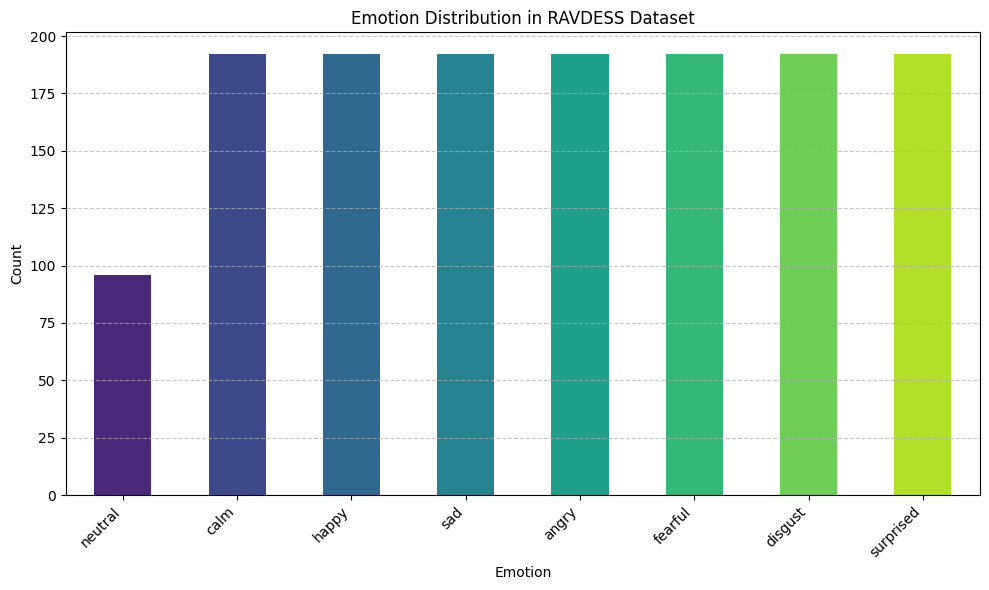

In [ ]:
# The following line prints a header to indicate the start of the dataset summary section, improving readability in the output.
print("\nDataset Summary:")

# The below line prints the total number of samples in the feature array X, providing a quick overview of the dataset size (e.g., 1440 samples).
print(f"Total samples: {len(X)}")

# The following line converts the labels array y into a pandas Series for easier manipulation and analysis of emotion counts.
label_series = pd.Series(y)

# The below line prints a subheader to introduce the emotion distribution, setting the context for the subsequent count output.
print("Emotion distribution:")

# The following line prints the count of each emotion in the dataset, using value_counts() to show how many samples belong to each emotion (e.g., neutral, happy).
print(label_series.value_counts())

# The below line creates a new figure for plotting with a size of 10x6 inches, ensuring the visualization is clear and appropriately proportioned.
plt.figure(figsize=(10, 6))

# The following line is a comment noting that the plot uses emotion_list for consistent ordering, ensuring emotions are displayed in a predefined sequence (neutral, calm, etc.).
# Plot in the order defined in emotion_list for consistency
# The below line generates a bar plot of emotion counts, ordered by emotion_list, using the viridis color palette to visually distinguish emotions.
label_series.value_counts().loc[emotion_list].plot(kind='bar', color=sns.color_palette("viridis", len(emotion_list)))

# The following line sets the plot title to describe the visualization, indicating it represents the emotion distribution in the RAVDESS dataset.
plt.title('Emotion Distribution in RAVDESS Dataset')

# The below line labels the x-axis as "Emotion", clearly indicating that the horizontal axis represents different emotion categories.
plt.xlabel('Emotion')

# The following line labels the y-axis as "Count", showing that the vertical axis represents the number of samples per emotion.
plt.ylabel('Count')

# The below line rotates the x-axis labels by 45 degrees and aligns them to the right, improving readability for emotion names.
plt.xticks(rotation=45, ha='right')

# The following line adds a horizontal grid to the y-axis with a dashed style and 70% opacity, aiding in visually estimating counts.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# The below line adjusts the plot layout to prevent overlapping elements, ensuring a clean and professional appearance.
plt.tight_layout()

# The following line is a commented-out instruction to save the plot as a PNG file, which could be enabled to store the visualization for reports or presentations.
# plt.savefig('emotion_distribution_pytorch.png')
# The below line displays the plot in the notebook, rendering the bar chart for immediate visual analysis of the emotion distribution.
plt.show()

Generating sample spectrograms...
  Generated spectrogram for neutral
  Generated spectrogram for calm
  Generated spectrogram for happy
  Generated spectrogram for sad
  Generated spectrogram for angry
  Generated spectrogram for fearful
  Generated spectrogram for disgust
  Generated spectrogram for surprised


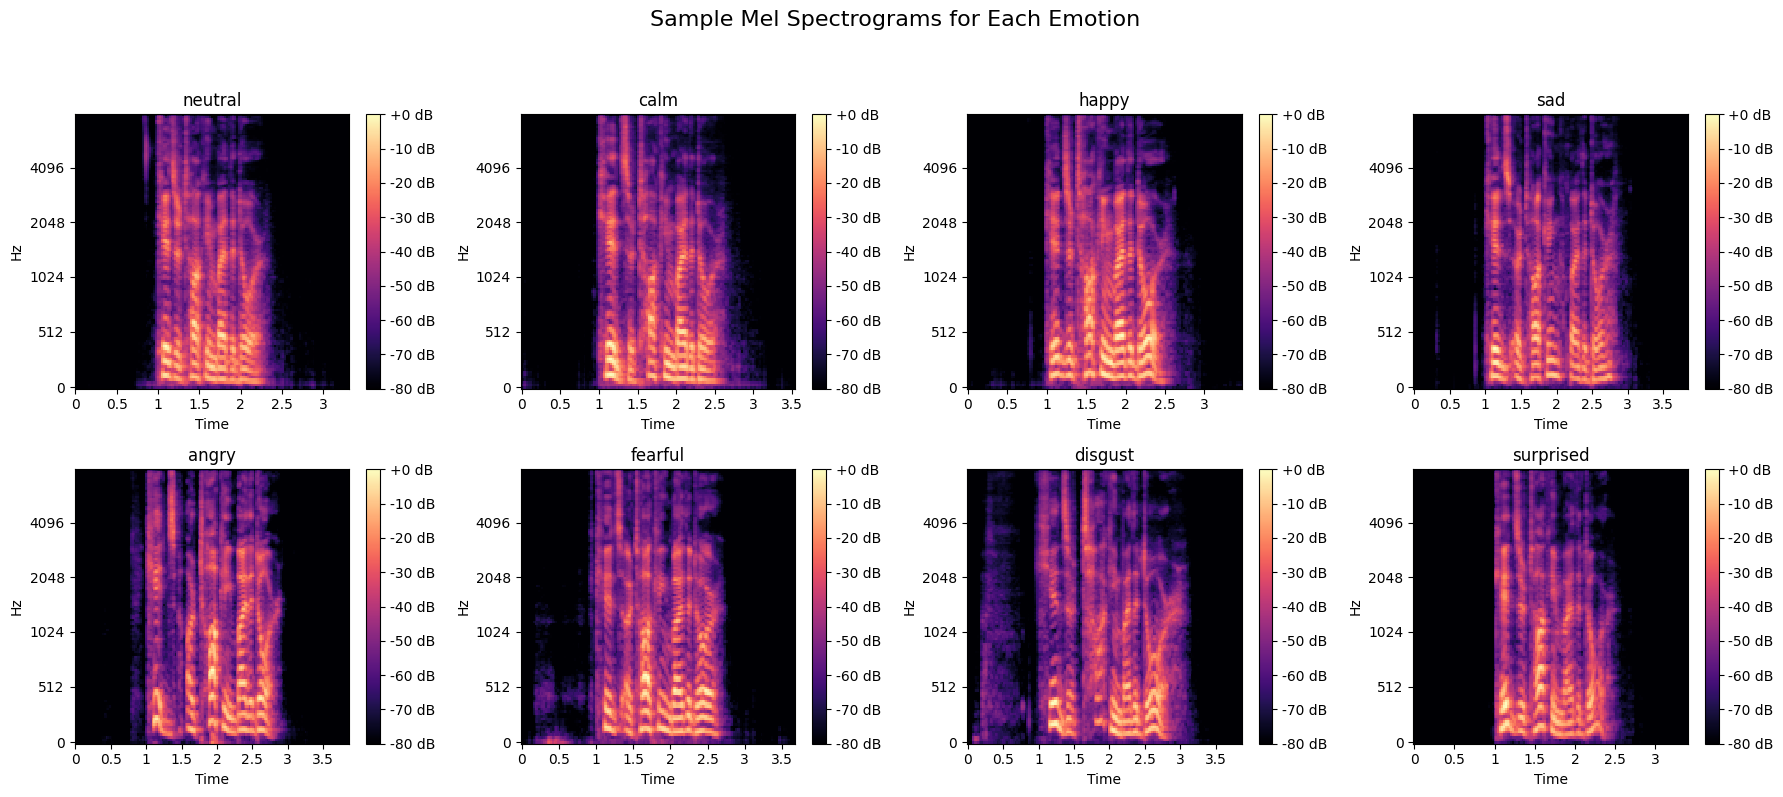

In [ ]:
# The following function defines a utility to compute the Mel spectrogram for an audio file without displaying it.
def get_mel_spectrogram(file_path):

    # The below line loads the audio file at a sample rate of 22050 Hz using librosa.
    audio, sr = librosa.load(file_path, sr=22050)

    # The below line computes the Mel spectrogram with 128 mel bands, matching the feature extraction settings.
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)

    # The below line converts the Mel spectrogram to decibel scale for better visualization.
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # The below line returns the decibel-scaled Mel spectrogram and sample rate.
    return mel_spec_db, sr

# The below line initializes an empty list to store spectrogram data (spectrogram, sample rate, emotion) for each emotion.
spectrogram_data = []

# The below line creates an empty set to track which emotions have been processed to ensure one sample per emotion.
processed_emotions = set()

# The below line prints a status message to indicate the start of spectrogram generation.
print("Generating sample spectrograms...")

# The below line iterates over actor folders in the data directory, sorted for consistent processing order.
for actor_folder in sorted(os.listdir(data_dir)):

    # The below line constructs the full path to the current actor folder.
    actor_path = os.path.join(data_dir, actor_folder)

    # The below line checks if the current path is a directory (i.e., an actor folder).
    if os.path.isdir(actor_path):

        # The below line iterates over audio files in the actor folder, sorted for reproducibility.
        for file_name in sorted(os.listdir(actor_path)):

            # The below line checks if the file is a WAV audio file.
            if file_name.endswith('.wav'):

                # The below line wraps the following code in a try-except block to handle potential errors during processing.
                try:

                    # The below line extracts the emotion code from the filename (third part of the filename split by '-').
                    emotion_code = file_name.split('-')[2]

                    # The below line checks if the emotion code is valid (exists in the emotions dictionary).
                    if emotion_code in emotions:

                        # The below line retrieves the emotion label corresponding to the emotion code.
                        emotion = emotions[emotion_code]

                        # The below line checks if this emotion has not yet been processed to ensure one sample per emotion.
                        if emotion not in processed_emotions:

                            # The below line constructs the full path to the audio file.
                            file_path = os.path.join(actor_path, file_name)

                            # The below line computes the Mel spectrogram and retrieves the sample rate for the audio file.
                            mel_spec_db, sr = get_mel_spectrogram(file_path)

                            # The below line appends a tuple of spectrogram, sample rate, and emotion to the data list.
                            spectrogram_data.append((mel_spec_db, sr, emotion))

                            # The below line adds the emotion to the set of processed emotions.
                            processed_emotions.add(emotion)

                            # The below line prints a confirmation message for the generated spectrogram.
                            print(f"  Generated spectrogram for {emotion}")

                            # The below line checks if all emotions have been processed to exit the inner loop early.
                            if len(processed_emotions) == len(emotions):

                                # The below line breaks the inner loop once one sample per emotion is found.
                                break

                # The below line catches and handles any errors during file processing, printing an error message.
                except Exception as e:

                    # The below line prints an error message with the filename and exception details.
                    print(f"Error processing file {file_name} for spectrogram: {e}")

        # The below line checks if all emotions have been processed to exit the outer loop early.
        if len(processed_emotions) == len(emotions):

            # The below line breaks the outer loop once all emotions have samples.
            break

# The below line sorts the spectrogram data by emotion index (based on emotion_list) for consistent plotting order.
spectrogram_data.sort(key=lambda item: emotion_list.index(item[2]))

# The below line sets the number of columns for the subplot grid (4 columns for 8 emotions).
cols = 4

# The below line calculates the number of rows needed based on the number of spectrograms, rounded up.
rows = int(np.ceil(len(spectrogram_data) / cols))

# The below line creates a figure with a subplot grid of specified rows and columns, sized for clarity.
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))

# The below line flattens the axes array for easier indexing in the loop.
axes = axes.flatten()

# The below line iterates over the spectrogram data with index to plot each spectrogram in the grid.
for idx, (mel_spec_db, sr, emotion) in enumerate(spectrogram_data):

    # The below line checks if the index is within the range of available axes to prevent out-of-bounds errors.
    if idx < len(axes):

        # The below line assigns the current axis for plotting.
        ax = axes[idx]

        # The below line displays the Mel spectrogram with time and mel frequency axes, capped at 8000 Hz.
        img = librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)

        # The below line sets the title of the subplot to the corresponding emotion.
        ax.set_title(f'{emotion}')

        # The below line adds a colorbar to the subplot, formatted to show decibel values.
        fig.colorbar(img, ax=ax, format='%+2.0f dB')

# The below line iterates over unused axes (if any) to hide them from the plot.
for i in range(len(spectrogram_data), len(axes)):

    # The below line removes the unused axis from the figure to avoid empty subplots.
    fig.delaxes(axes[i])

# The below line sets the overall title for the figure, positioned slightly above for clarity.
plt.suptitle('Sample Mel Spectrograms for Each Emotion', fontsize=16, y=1.02)

# The below line adjusts the layout to prevent overlap, reserving space for the title and colorbars.
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# The below line displays the final plot with all spectrograms.
plt.show()

## 4. Data Preprocessing

The extracted features and corresponding emotion labels are organized into numerical arrays. Labels are then encoded into numerical format using `LabelEncoder`, the data is split into training and testing sets, and finally, the features are scaled using `StandardScaler`.

In [ ]:
# The below line imports the LabelEncoder from scikit-learn to convert categorical labels to integers
from sklearn.preprocessing import LabelEncoder

# The below line initializes a LabelEncoder instance to encode emotion labels
le = LabelEncoder()

# The following line fits the LabelEncoder to the categorical labels (y) and transforms them into integers
y_encoded = le.fit_transform(y)

# The below line calculates the number of unique classes (emotions) from the encoded labels
num_classes = len(le.classes_)

# The following line prints the number of emotion classes for verification
print(f"Labels encoded into integers. Number of classes: {num_classes}")

# The below line prints a dictionary mapping original emotion labels to their encoded integers
print(f"Class mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# The below line imports train_test_split from scikit-learn to split the dataset into training and test sets
from sklearn.model_selection import train_test_split

# The following line splits the features (X) and encoded labels (y_encoded) into 80% training and 20% test sets, using stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded # Stratify based on encoded integer labels
)

# The below line imports torch to enable conversion of numpy arrays to PyTorch tensors
import torch

# The following line converts the training features (X_train) from a numpy array to a PyTorch float tensor
X_train = torch.tensor(X_train, dtype=torch.float32)

# The below line converts the test features (X_test) from a numpy array to a PyTorch float tensor
X_test = torch.tensor(X_test, dtype=torch.float32)

# The following line converts the training labels (y_train) to a PyTorch long tensor, required for CrossEntropyLoss
y_train = torch.tensor(y_train, dtype=torch.long) # Use LongTensor for CrossEntropyLoss

# The below line converts the test labels (y_test) to a PyTorch long tensor, required for CrossEntropyLoss
y_test = torch.tensor(y_test, dtype=torch.long)

# The following line adds a channel dimension to X_train, reshaping it from [num_samples, num_features] to [num_samples, 1, num_features] for Conv1D input
X_train = X_train.unsqueeze(1) # Add channel dimension -> (N, 1, num_features)

# The below line adds a channel dimension to X_test, reshaping it from [num_samples, num_features] to [num_samples, 1, num_features] for Conv1D input
X_test = X_test.unsqueeze(1)

# The following line prints the shape of the training features to verify the correct dimensions for the model
print(f"X_train shape: {X_train.shape}") # Should be [num_samples, 1, num_features]

# The below line prints the shape of the test features to verify the correct dimensions
print(f"X_test shape: {X_test.shape}")

# The following line prints the shape of the training labels to ensure compatibility with the model
print(f"y_train shape: {y_train.shape}") # Should be [num_samples]

# The below line prints the shape of the test labels to ensure compatibility
print(f"y_test shape: {y_test.shape}")

# The below line imports TensorDataset and DataLoader from PyTorch to create datasets and batch iterators
from torch.utils.data import Dataset, DataLoader, TensorDataset

# The following line sets the batch size to 32, consistent with the project’s training configuration
batch_size = 32 # Match original notebook

# The below line creates a TensorDataset for the training data, pairing features (X_train) with labels (y_train)
train_dataset = TensorDataset(X_train, y_train)

# The following line creates a TensorDataset for the test data, pairing features (X_test) with labels (y_test)
test_dataset = TensorDataset(X_test, y_test)

# The below line creates a DataLoader for the training dataset, enabling batched and shuffled data iteration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# The following line creates a DataLoader for the test dataset, with batched data but no shuffling to maintain order
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# The below line prints a confirmation that DataLoaders have been created with the specified batch size
print(f"\nDataLoaders created with batch size {batch_size}.")

Labels encoded into integers. Number of classes: 8
Class mapping: {np.str_('angry'): np.int64(0), np.str_('calm'): np.int64(1), np.str_('disgust'): np.int64(2), np.str_('fearful'): np.int64(3), np.str_('happy'): np.int64(4), np.str_('neutral'): np.int64(5), np.str_('sad'): np.int64(6), np.str_('surprised'): np.int64(7)}
X_train shape: torch.Size([1152, 1, 231])
X_test shape: torch.Size([288, 1, 231])
y_train shape: torch.Size([1152])
y_test shape: torch.Size([288])

DataLoaders created with batch size 32.


## 5. Model Definition (CNN)

Define the Convolutional Neural Network (CNN) architecture using PyTorch's `nn.Module`. This CNN consists of multiple convolutional blocks followed by fully connected layers for classification.


In [ ]:
class SER_CNN(nn.Module):

    # The following line defines the constructor for the SER_CNN class, taking input_shape (e.g., (1, 231)) and num_classes (e.g., 8 for emotions).
    def __init__(self, input_shape, num_classes):

        # The below line calls the parent class (nn.Module) constructor to initialize the PyTorch module.
        super(SER_CNN, self).__init__()

        # The following line defines the first 1D convolutional layer with 1 input channel, 32 output channels, kernel size of 3, and same padding to maintain input size.
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding='same')

        # The below line initializes batch normalization for the 32 output channels to stabilize and accelerate training.
        self.bn1 = nn.BatchNorm1d(32)

        # The following line applies the ReLU activation function to introduce non-linearity after the first convolutional layer.
        self.relu1 = nn.ReLU()

        # The below line defines a max pooling layer with kernel size 2 and stride 2 to reduce the temporal dimension by half.
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # The following line defines the second 1D convolutional layer, taking 32 input channels from the previous layer and outputting 64 channels.
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding='same')

        # The below line initializes batch normalization for the 64 output channels to normalize activations.
        self.bn2 = nn.BatchNorm1d(64)

        # The following line applies ReLU activation to the output of the second convolutional layer for non-linearity.
        self.relu2 = nn.ReLU()

        # The below line applies max pooling with kernel size 2 and stride 2 to further reduce the temporal dimension.
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # The following line defines the third 1D convolutional layer, taking 64 input channels and outputting 128 channels for deeper feature extraction.
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding='same')

        # The below line initializes batch normalization for the 128 output channels to improve training stability.
        self.bn3 = nn.BatchNorm1d(128)

        # The following line applies ReLU activation to the third convolutional layer’s output.
        self.relu3 = nn.ReLU()

        # The below line applies max pooling with kernel size 2 and stride 2 to reduce the temporal dimension further.
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # The following line initializes a flatten layer to convert the convolutional output into a 1D vector for dense layers.
        self.flatten = nn.Flatten()

        # The below line creates a dummy input tensor with shape (1, input_shape) to compute the flattened size dynamically.
        dummy_input = torch.zeros(1, *input_shape)

        # The following line passes the dummy input through the convolutional and pooling layers to determine the output shape.
        dummy_output = self.pool3(self.relu3(self.bn3(self.conv3(
                        self.pool2(self.relu2(self.bn2(self.conv2(
                        self.pool1(self.relu1(self.bn1(self.conv1(dummy_input))))))))))))

        # The below line calculates the number of elements in the flattened output for the dense layer input size.
        flattened_size = dummy_output.numel()

        # The following line defines the first fully connected (dense) layer, mapping the flattened size to 256 units.
        self.fc1 = nn.Linear(flattened_size, 256)

        # The below line initializes batch normalization for the 256 units in the first dense layer.
        self.bn4 = nn.BatchNorm1d(256)

        # The following line applies ReLU activation to the first dense layer’s output.
        self.relu4 = nn.ReLU()

        # The below line applies dropout with a 50% probability to prevent overfitting in the first dense layer.
        self.dropout1 = nn.Dropout(0.5)

        # The following line defines the second dense layer, reducing from 256 to 128 units.
        self.fc2 = nn.Linear(256, 128)

        # The below line applies ReLU activation to the second dense layer’s output.
        self.relu5 = nn.ReLU()

        # The following line applies dropout with a 30% probability to reduce overfitting in the second dense layer.
        self.dropout2 = nn.Dropout(0.3)

        # The below line defines the final dense layer, mapping 128 units to the number of emotion classes (e.g., 8).
        self.fc3 = nn.Linear(128, num_classes)

    # The following line defines the forward pass method, specifying how input data flows through the network.
    def forward(self, x):

        # The below line applies the first convolutional layer to the input tensor (e.g., shape [batch, 1, 231]).
        x = self.conv1(x)

        # The following line normalizes the output of the first convolutional layer using batch normalization.
        x = self.bn1(x)

        # The below line applies ReLU activation to introduce non-linearity.
        x = self.relu1(x)

        # The following line reduces the temporal dimension via max pooling.
        x = self.pool1(x)

        # The below line applies the second convolutional layer to extract higher-level features.
        x = self.conv2(x)

        # The following line normalizes the output of the second convolutional layer.
        x = self.bn2(x)

        # The below line applies ReLU activation to the second convolutional output.
        x = self.relu2(x)

        # The following line further reduces the temporal dimension with max pooling.
        x = self.pool2(x)


        # The below line applies the third convolutional layer for deeper feature extraction.
        x = self.conv3(x)

        # The following line normalizes the output of the third convolutional layer.
        x = self.bn3(x)

        # The below line applies ReLU activation to the third convolutional output.
        x = self.relu3(x)

        # The following line reduces the temporal dimension with max pooling.
        x = self.pool3(x)

        # The below line flattens the convolutional output into a 1D vector for dense layer processing.
        x = self.flatten(x)

        # The following line applies the first dense layer to the flattened features.
        x = self.fc1(x)

        # The below line normalizes the output of the first dense layer.
        x = self.bn4(x)

        # The following line applies ReLU activation to the first dense layer output.
        x = self.relu4(x)

        # The below line applies dropout to prevent overfitting during training.
        x = self.dropout1(x)

        # The following line applies the second dense layer to further process features.
        x = self.fc2(x)

        # The below line applies ReLU activation to the second dense layer output.
        x = self.relu5(x)

        # The following line applies dropout to reduce overfitting.
        x = self.dropout2(x)

        # The below line applies the final dense layer to produce logits for each emotion class.
        x = self.fc3(x)

        # The following line returns the model’s output (logits for classification).
        return x

In [ ]:
# The following line defines a function to perform k-fold cross-validation for the SER model, evaluating its performance across multiple data splits.
def cross_validate_model(X, y_encoded, n_splits=5, epochs=30, batch_size=32, lr=0.001):

    # The following line initializes a KFold object to split the data into n_splits folds, shuffling for randomness with a fixed seed for reproducibility.
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # The following line creates an empty list to store the validation accuracy for each fold.
    fold_accuracies = []

    # The following line starts a loop over each fold, enumerating the train and validation indices generated by KFold.
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):

        # The following line prints the current fold number to track progress during cross-validation.
        print(f"\nTraining fold {fold+1}/{n_splits}")


        # The following line splits the feature matrix X into training and validation sets for the current fold using the provided indices.
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]

        # The following line splits the encoded labels y_encoded into training and validation sets for the current fold.
        y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]

        # The following line converts the training features to a PyTorch tensor with float32 dtype and adds a channel dimension for CNN input (shape: [batch, 1, 231]).
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32).unsqueeze(1)

        # The following line converts the validation features to a PyTorch tensor with float32 dtype and adds a channel dimension.
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32).unsqueeze(1)

        # The following line converts the training labels to a PyTorch tensor with long dtype for classification.
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)

        # The following line converts the validation labels to a PyTorch tensor with long dtype.
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)

        # The following line creates a TensorDataset combining the training features and labels for efficient batching.
        train_dataset = TensorDataset(X_train_fold, y_train_fold)

        # The following line creates a TensorDataset combining the validation features and labels.
        val_dataset = TensorDataset(X_val_fold, y_val_fold)

        # The following line creates a DataLoader for the training dataset, enabling batch processing with shuffling for better training.
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # The following line creates a DataLoader for the validation dataset, using the specified batch size without shuffling.
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # The following line initializes a new SER_CNN model for the current fold, setting input shape to (1, 231) and num_classes to the number of unique emotions (8).
        fold_model = SER_CNN(input_shape=(1, X.shape[1]), num_classes=len(np.unique(y_encoded))).to(device)

        # The following line sets up the Adam optimizer with the specified learning rate and L2 regularization (weight decay) to prevent overfitting.
        optimizer = optim.Adam(fold_model.parameters(), lr=lr, weight_decay=1e-5)

        # The following line defines the CrossEntropyLoss function to compute the loss between predicted and true labels.
        criterion = nn.CrossEntropyLoss()

        # The following line starts a loop over the specified number of epochs for training the model.
        for epoch in range(epochs):

            # The following line sets the model to training mode, enabling dropout and batch normalization.
            fold_model.train()

            # The following line iterates over batches of training data from the train_loader.
            for inputs, labels in train_loader:

                # The following line moves the input features and labels to the specified device (GPU or CPU).
                inputs, labels = inputs.to(device), labels.to(device)

                # The following line clears the gradients from the previous iteration to prevent accumulation.
                optimizer.zero_grad()

                # The following line passes the inputs through the model to get predicted outputs.
                outputs = fold_model(inputs)

                # The following line computes the loss between the predicted outputs and true labels.
                loss = criterion(outputs, labels)

                # The following line performs backpropagation to compute gradients.
                loss.backward()

                # The following line updates the model parameters using the computed gradients.
                optimizer.step()

            # The following line sets the model to evaluation mode, disabling dropout and batch normalization.
            fold_model.eval()

            # The following line initializes a counter for correct predictions during validation.
            correct = 0

            # The following line initializes a counter for the total number of validation samples.
            total = 0

            # The following line ensures no gradients are computed during validation to save memory and speed up inference.
            with torch.no_grad():

                # The following line iterates over batches of validation data from the val_loader.
                for inputs, labels in val_loader:

                    # The following line moves the validation inputs and labels to the specified device.
                    inputs, labels = inputs.to(device), labels.to(device)

                    # The following line passes the validation inputs through the model to get outputs.
                    outputs = fold_model(inputs)

                    # The following line gets the predicted class indices by selecting the class with the highest output score.
                    _, predicted = torch.max(outputs.data, 1)

                    # The following line updates the total number of validation samples processed.
                    total += labels.size(0)

                    # The following line counts the number of correct predictions by comparing predicted and true labels.
                    correct += (predicted == labels).sum().item()

            # The following line calculates the validation accuracy for the current epoch as the ratio of correct predictions to total samples.
            fold_accuracy = correct / total

            # The following line prints the epoch number and validation accuracy to monitor training progress.
            print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {fold_accuracy:.4f}")

        # The following line sets the model to evaluation mode again for final fold accuracy computation.
        fold_model.eval()

        # The following line resets the counter for correct predictions for the final fold evaluation.
        correct = 0

        # The following line resets the counter for the total number of validation samples.
        total = 0

        # The following line ensures no gradients are computed during final evaluation.
        with torch.no_grad():

            # The following line iterates over the validation data again for final accuracy.
            for inputs, labels in val_loader:

                # The following line moves the validation inputs and labels to the device.
                inputs, labels = inputs.to(device), labels.to(device)

                # The following line passes the inputs through the model to get final outputs.
                outputs = fold_model(inputs)

                # The following line gets the predicted class indices for the final evaluation.
                _, predicted = torch.max(outputs.data, 1)

                # The following line updates the total number of samples processed.
                total += labels.size(0)

                # The following line counts the number of correct predictions.
                correct += (predicted == labels).sum().item()

        # The following line calculates the final validation accuracy for the current fold.
        fold_accuracy = correct / total

        # The following line appends the final fold accuracy to the list of fold accuracies.
        fold_accuracies.append(fold_accuracy)

        # The following line prints the final accuracy for the current fold.
        print(f"Fold {fold+1} final accuracy: {fold_accuracy:.4f}")

    # The following line prints a message indicating that cross-validation is complete.
    print(f"\nCross-validation complete!")

    # The following line prints the mean accuracy across all folds to summarize model performance.
    print(f"Mean accuracy across {n_splits} folds: {np.mean(fold_accuracies):.4f}")

    # The following line prints the standard deviation of fold accuracies to assess performance stability.
    print(f"Standard deviation: {np.std(fold_accuracies):.4f}")

    # The following line returns the list of fold accuracies for further analysis.
    return fold_accuracies

In [ ]:
# The following line defines a function to create an ensemble of SER_CNN models with different initializations
def create_ensemble(X_train, y_train, X_test, y_test, num_models=3):
    """Create an ensemble of models with different initializations."""

    # The below line initializes an empty list to store the ensemble models
    models = []

    # The below line starts a loop to create and train each model in the ensemble
    for i in range(num_models):

        # The below line prints a status message indicating which model is being trained
        print(f"\nTraining model {i+1}/{num_models} for ensemble")

        # The below line creates a new SER_CNN model with input shape matching X_train and number of classes from unique labels
        model = SER_CNN(input_shape=(1, X_train.shape[2]), num_classes=len(np.unique(y_train))).to(device)

        # The below line sets a unique learning rate for each model to promote diversity, scaled between 0.8x and 1.2x of 0.001
        lr = 0.001 * (0.8 + (i * 0.2))

        # The below line initializes an Adam optimizer with the specified learning rate and weight decay for regularization
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

        # The below line defines the CrossEntropyLoss function for classification
        criterion = nn.CrossEntropyLoss()

        # The below line creates a TensorDataset from training features and labels for efficient data loading
        train_dataset = TensorDataset(X_train, y_train)

        # The below line creates a DataLoader to batch and shuffle training data
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # The below line starts a loop to train the model for 30 epochs
        for epoch in range(30):

            # The below line sets the model to training mode, enabling dropout and batch normalization
            model.train()

            # The below line iterates over batches of training data
            for inputs, labels in train_loader:

                # The below line moves input features and labels to the specified device (GPU or CPU)
                inputs, labels = inputs.to(device), labels.to(device)

                # The below line clears accumulated gradients from previous iterations
                optimizer.zero_grad()

                # The below line computes model outputs by forward passing the inputs
                outputs = model(inputs)

                # The below line calculates the loss between predicted outputs and true labels
                loss = criterion(outputs, labels)

                # The below line performs backpropagation to compute gradients
                loss.backward()

                # The below line updates model parameters using the optimizer
                optimizer.step()

        # The below line adds the trained model to the ensemble list
        models.append(model)

        # The below line sets the model to evaluation mode, disabling dropout and batch normalization
        model.eval()

        # The below line initializes counters for correct predictions and total samples
        correct = 0

        # The below line initializes a counter for total samples
        total = 0

        # The below line disables gradient computation for evaluation to save memory
        with torch.no_grad():

            # The below line iterates over test data batches using a DataLoader
            for inputs, labels in DataLoader(TensorDataset(X_test, y_test), batch_size=32):

                # The below line moves test inputs and labels to the specified device
                inputs, labels = inputs.to(device), labels.to(device)

                # The below line computes model outputs for the test inputs
                outputs = model(inputs)

                # The below line gets the predicted class indices by finding the maximum output probability
                _, predicted = torch.max(outputs.data, 1)

                # The below line updates the total number of samples processed
                total += labels.size(0)

                # The below line counts the number of correct predictions
                correct += (predicted == labels).sum().item()

        # The below line calculates the accuracy of the individual model
        accuracy = correct / total

        # The below line prints the accuracy of the individual model
        print(f"Model {i+1} individual accuracy: {accuracy:.4f}")

    # The below line returns the list of trained ensemble models
    return models

# The following line defines a function to make predictions using the ensemble by averaging model outputs
def predict_with_ensemble(models, X):
    """Make predictions using ensemble averaging."""

    # The below line initializes an empty list to store predictions from each model
    all_predictions = []

    # The below line iterates over each model in the ensemble
    for model in models:

        # The below line sets the model to evaluation mode for inference
        model.eval()

        # The below line disables gradient computation for prediction to save memory
        with torch.no_grad():

            # The below line computes model outputs for the input features
            outputs = model(X)

            # The below line converts output logits to probabilities using softmax
            probabilities = torch.softmax(outputs, dim=1)

            # The below line converts probabilities to a NumPy array and adds to the predictions list
            all_predictions.append(probabilities.cpu().numpy())

    # The below line averages the predictions across all models
    avg_predictions = np.mean(all_predictions, axis=0)

    # The below line returns the predicted class indices by selecting the class with the highest average probability
    return np.argmax(avg_predictions, axis=1)

## 6. Model Training

Instantiate the model, define the loss function (CrossEntropyLoss), the optimizer (Adam), and a learning rate scheduler (ReduceLROnPlateau). Set up the device (GPU if available, else CPU). Then, run the training loop for a specified number of epochs, tracking training and validation loss/accuracy. Includes early stopping logic.


In [ ]:
# The below line imports KFold from sklearn for cross-validation
from sklearn.model_selection import KFold

# The following line imports soundfile for audio file handling
import soundfile as sf

# The below line extracts the input shape from training data, excluding batch dimension
input_shape = X_train.shape[1:] # Get (channels, features) -> (1, 180)

# The following line initializes the SER_CNN model with the extracted input shape and moves it to the specified device (CPU or GPU)
model = SER_CNN(input_shape, num_classes).to(device)

# The below line prints a header for the model summary
print("PyTorch Model Summary:")

# The following line prints the model architecture
print(model)

# The below line initializes the Cross Entropy Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()
# The following line sets up the Adam optimizer with learning rate 0.001 and weight decay 1e-5 for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# The below line initializes a learning rate scheduler that reduces the learning rate when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(

    # The following line passes the optimizer to the scheduler
    optimizer,

    # The below line sets the scheduler to monitor for minimum validation loss
    mode='min',

    # The following line sets the factor by which learning rate will be reduced (multiplied by 0.5)
    factor=0.5,

    # The below line sets the number of epochs with no improvement after which learning rate will be reduced
    patience=5,

    # The following line sets the minimum learning rate threshold
    min_lr=1e-6,

    # The below line enables verbose output when learning rate changes
    verbose=True
)

# The following line sets the total number of training epochs
epochs = 100  # Increased from 50

# The below line sets the batch size for training
batch_size = 32

# The following line initializes a dictionary to store training and validation metrics history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# The below line sets the number of epochs to wait before early stopping when no improvement is observed
early_stopping_patience = 10

# The following line initializes the best validation loss with infinity for comparison
best_val_loss = float('inf')

# The below line initializes the counter for early stopping
early_stopping_counter = 0

# The following line initializes a variable to store the best model state
best_model_state = None

# The below line prints a message indicating training is starting
print("\nStarting training...")

# The following line records the starting time for training duration calculation
start_time = time.time()

# The below line starts a loop that iterates through each epoch
for epoch in range(epochs):

    # The following line indicates the start of training phase
    # --- Training Phase ---

    # The below line sets the model to training mode (enables dropout, batch normalization updates)
    model.train()

    # The following line initializes the running loss for the current epoch
    running_loss = 0.0

    # The below line initializes the counter for correctly predicted training samples
    correct_train = 0

    # The following line initializes the counter for total training samples
    total_train = 0

    # The below line starts a loop that iterates through each batch in the training dataset
    for inputs, labels in train_loader:

        # The following line moves the input data and labels to the specified device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # The below line zeros the parameter gradients to prevent accumulation from previous batches
        optimizer.zero_grad()

        # The following line performs the forward pass by passing inputs through the model
        outputs = model(inputs)

        # The below line calculates the loss between predicted outputs and true labels
        loss = criterion(outputs, labels)

        # The following line performs backpropagation by computing gradients of the loss
        loss.backward()

        # The below line updates model parameters based on computed gradients
        optimizer.step()

        # The following line accumulates the batch loss multiplied by batch size
        running_loss += loss.item() * inputs.size(0)

        # The below line gets the index of the highest probability class for each sample
        _, predicted = torch.max(outputs.data, 1)

        # The following line increments the total number of processed training samples
        total_train += labels.size(0)

        # The below line counts how many predictions match the true labels
        correct_train += (predicted == labels).sum().item()

    # The following line calculates the average training loss for the current epoch
    epoch_train_loss = running_loss / len(train_loader.dataset)

    # The below line calculates the training accuracy for the current epoch
    epoch_train_acc = correct_train / total_train

    # The following line stores the training loss in the history dictionary
    history['train_loss'].append(epoch_train_loss)

    # The below line stores the training accuracy in the history dictionary
    history['train_acc'].append(epoch_train_acc)

    # The following line indicates the start of validation phase
    # --- Validation Phase ---
    # The below line sets the model to evaluation mode (disables dropout, uses running stats for batch norm)
    model.eval()

    # The following line initializes the running validation loss for the current epoch
    running_val_loss = 0.0

    # The below line initializes the counter for correctly predicted validation samples
    correct_val = 0

    # The following line initializes the counter for total validation samples
    total_val = 0

    # The below line creates a context where gradients are not calculated to save memory and speed up validation
    with torch.no_grad():

        # The following line starts a loop that iterates through each batch in the validation dataset
        for inputs, labels in test_loader:

            # The below line moves the input data and labels to the specified device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # The following line performs the forward pass for validation data
            outputs = model(inputs)

            # The below line calculates the validation loss
            loss = criterion(outputs, labels)

            # The following line accumulates the validation batch loss multiplied by batch size
            running_val_loss += loss.item() * inputs.size(0)

            # The below line gets the index of the highest probability class for each validation sample
            _, predicted = torch.max(outputs.data, 1)

            # The following line increments the total number of processed validation samples
            total_val += labels.size(0)

            # The below line counts how many validation predictions match the true labels
            correct_val += (predicted == labels).sum().item()

    # The following line calculates the average validation loss for the current epoch
    epoch_val_loss = running_val_loss / len(test_loader.dataset)

    # The below line calculates the validation accuracy for the current epoch
    epoch_val_acc = correct_val / total_val

    # The following line stores the validation loss in the history dictionary
    history['val_loss'].append(epoch_val_loss)

    # The below line stores the validation accuracy in the history dictionary
    history['val_acc'].append(epoch_val_acc)

    # The below line updates the learning rate based on validation loss
    scheduler.step(epoch_val_loss)

    # The following line indicates where early stopping check would be implemented
    # Early stopping check

    # The below line prints the training and validation metrics for the current epoch
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

# The following line checks if a best model state was saved during training
if best_model_state is not None:

    # The below line loads the best model state to restore the best performing model
    model.load_state_dict(best_model_state)

# The following line records the end time of training
end_time = time.time()

# The below line prints the total training duration in seconds
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")


PyTorch Model Summary:
SER_CNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3584, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, tr

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting training...
Epoch [1/100] | Train Loss: 1.9163 | Train Acc: 0.2465 | Val Loss: 1.9579 | Val Acc: 0.1840
Epoch [2/100] | Train Loss: 1.7610 | Train Acc: 0.3064 | Val Loss: 2.6402 | Val Acc: 0.1562
Epoch [3/100] | Train Loss: 1.6502 | Train Acc: 0.3672 | Val Loss: 2.5391 | Val Acc: 0.1979
Epoch [4/100] | Train Loss: 1.5715 | Train Acc: 0.4036 | Val Loss: 1.9195 | Val Acc: 0.2986
Epoch [5/100] | Train Loss: 1.4751 | Train Acc: 0.4366 | Val Loss: 2.2010 | Val Acc: 0.2986
Epoch [6/100] | Train Loss: 1.3863 | Train Acc: 0.4774 | Val Loss: 4.1655 | Val Acc: 0.1771
Epoch [7/100] | Train Loss: 1.3071 | Train Acc: 0.5095 | Val Loss: 3.4465 | Val Acc: 0.2604
Epoch [8/100] | Train Loss: 1.2673 | Train Acc: 0.5304 | Val Loss: 7.3299 | Val Acc: 0.1424
Epoch [9/100] | Train Loss: 1.1932 | Train Acc: 0.5460 | Val Loss: 3.0271 | Val Acc: 0.2986
Epoch [10/100] | Train Loss: 1.1823 | Train Acc: 0.5729 | Val Loss: 6.4088 | Val Acc: 0.2465
Epoch [11/100] | Train Loss: 1.1047 | Train Acc: 0.5885 |

In [ ]:
# The following line retrieves the validation accuracy from the last epoch in the training history
final_val_acc = history['val_acc'][-1]

# The following line retrieves the validation loss from the last epoch in the training history
final_val_loss = history['val_loss'][-1]

# The below line prints the final test loss value formatted to 4 decimal places
print(f"\nFinal Test Loss: {final_val_loss:.4f}")

# The below line prints the final test accuracy as a percentage, formatted to 2 decimal places
print(f"Final Test Accuracy: {final_val_acc*100:.2f}%")

# The following line sets the model to evaluation mode, which disables operations like dropout
model.eval()

# The below line initializes an empty list to store all model predictions
all_preds = []

# The below line initializes an empty list to store all true labels
all_labels = []

# The following line creates a context manager that disables gradient calculation to speed up inference
with torch.no_grad():

    # The below line iterates through batches of test data from the test data loader
    for inputs, labels in test_loader:

        # The following line moves the input tensors and label tensors to the appropriate device (CPU/GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # The below line passes the inputs through the model to get the predictions
        outputs = model(inputs)

        # The following line gets the index of the highest probability class for each sample
        _, predicted = torch.max(outputs.data, 1)

        # The below line adds the batch predictions to our list after moving them to CPU and converting to NumPy
        all_preds.extend(predicted.cpu().numpy())

        # The below line adds the batch true labels to our list after moving them to CPU and converting to NumPy
        all_labels.extend(labels.cpu().numpy())

# The following line converts the prediction list to a NumPy array for easier processing
y_pred_classes = np.array(all_preds)

# The below line converts the true labels list to a NumPy array
y_test_classes = np.array(all_labels)

# The following line prints a header for the classification report
print("\nClassification Report:")

# The below line generates and prints a detailed classification report showing precision, recall,
# F1-score, and support for each emotion class using the original emotion labels as class names
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))



Final Test Loss: 1.0913
Final Test Accuracy: 71.53%

Classification Report:
              precision    recall  f1-score   support

       angry       0.82      0.74      0.78        38
        calm       0.73      0.87      0.80        38
     disgust       0.69      0.71      0.70        38
     fearful       0.62      0.74      0.67        39
       happy       0.69      0.51      0.59        39
     neutral       0.59      0.53      0.56        19
         sad       0.71      0.63      0.67        38
   surprised       0.81      0.90      0.85        39

    accuracy                           0.72       288
   macro avg       0.71      0.70      0.70       288
weighted avg       0.72      0.72      0.71       288



## 7. Training History Visualization

Plot the training and validation accuracy and loss curves over epochs to visualize the model's learning progress and check for overfitting.


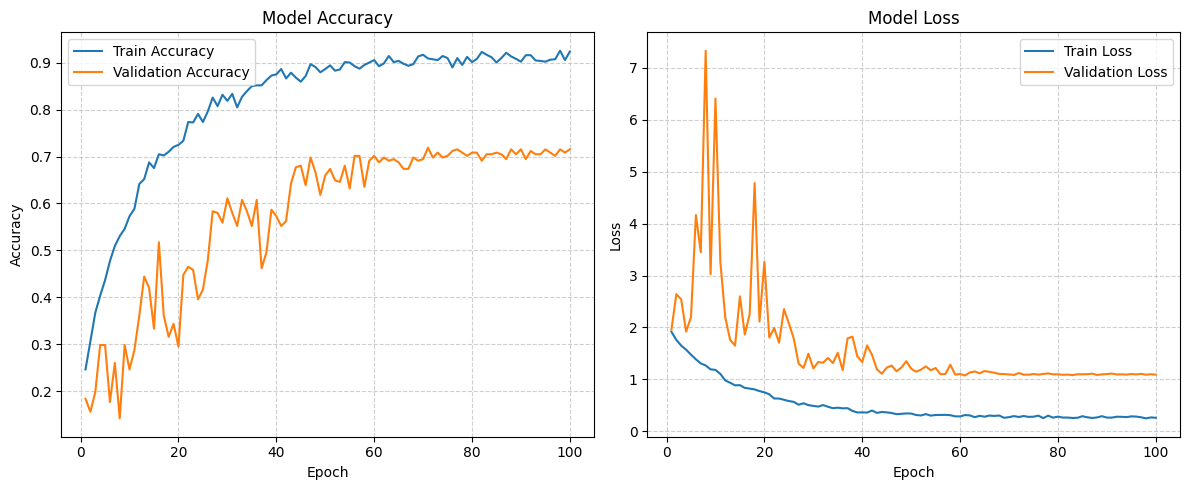

In [ ]:
# The below line creates a new figure for plotting with a specified size of 12 inches wide by 5 inches tall, providing ample space for two subplots.
plt.figure(figsize=(12, 5))

# The following line initiates the first subplot in a 1x2 grid (1 row, 2 columns), positioned at index 1, to display accuracy metrics.
plt.subplot(1, 2, 1)

# The below line plots the training accuracy over epochs, using a range from 1 to the number of recorded training accuracy values, with a label for identification in the legend.
plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label='Train Accuracy')

# The following line plots the validation accuracy over epochs, using a range from 1 to the number of recorded validation accuracy values, with a label for the legend.
plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label='Validation Accuracy')

# The below line sets the title of the first subplot to 'Model Accuracy' to clearly indicate the content being visualized.
plt.title('Model Accuracy')

# The following line labels the x-axis as 'Epoch' to represent the training iterations over time.
plt.xlabel('Epoch')

# The below line labels the y-axis as 'Accuracy' to indicate the metric being measured.
plt.ylabel('Accuracy')

# The following line adds a legend to the plot to distinguish between training and validation accuracy lines.
plt.legend()

# The below line adds a grid to the plot for better readability of data points, with a dashed style and slight transparency.
plt.grid(True, linestyle='--', alpha=0.6)

# The following line initiates the second subplot in the 1x2 grid, positioned at index 2, to display loss metrics.
plt.subplot(1, 2, 2)

# The below line plots the training loss over epochs, using a range from 1 to the number of recorded training loss values, with a label for the legend.
plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label='Train Loss')

# The following line plots the validation loss over epochs, using a range from 1 to the number of recorded validation loss values, with a label for the legend.
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='Validation Loss')

# The below line sets the title of the second subplot to 'Model Loss' to clearly indicate the content being visualized.
plt.title('Model Loss')

# The following line labels the x-axis as 'Epoch' to represent the training iterations over time.
plt.xlabel('Epoch')

# The below line labels the y-axis as 'Loss' to indicate the metric being measured.
plt.ylabel('Loss')

# The following line adds a legend to the plot to distinguish between training and validation loss lines.
plt.legend()

# The below line adds a grid to the plot for better readability of data points, with a dashed style and slight transparency.
plt.grid(True, linestyle='--', alpha=0.6)

# The following line adjusts the layout of the subplots to prevent overlap and ensure a clean presentation of the visualizations.
plt.tight_layout()

# The below line displays the final figure with both accuracy and loss plots, rendering it visible in the output.
plt.show()


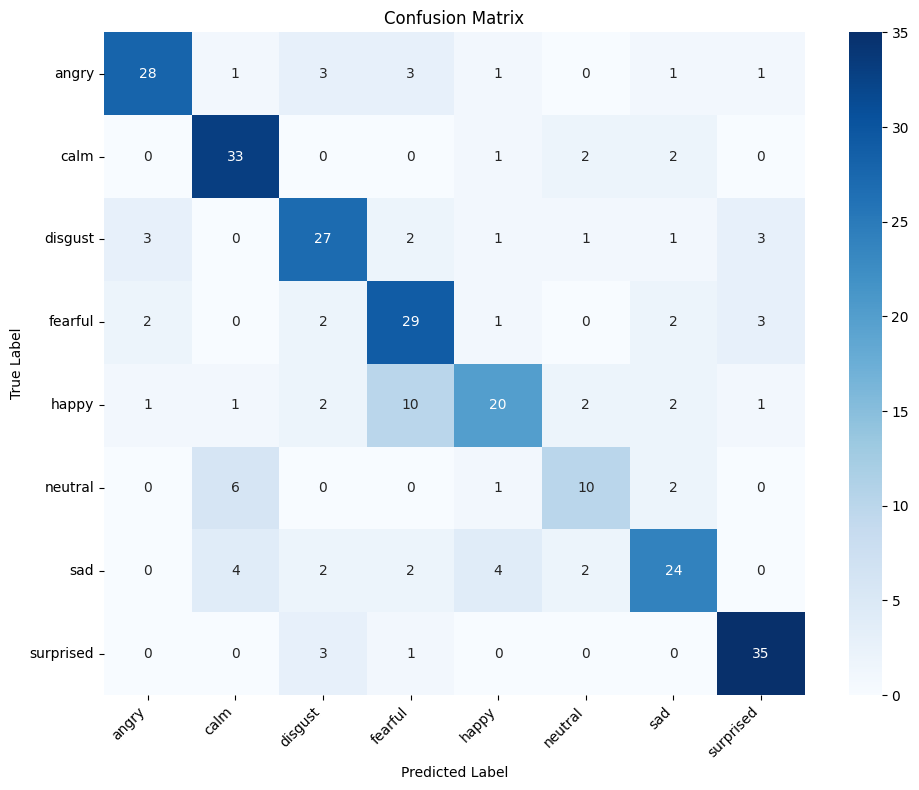

In [ ]:
# The following line creates a confusion matrix using the true labels (y_test_classes) and predicted labels (y_pred_classes) to evaluate the model's performance by showing the counts of correct and incorrect predictions across classes.
cm = confusion_matrix(y_test_classes, y_pred_classes)

# The following line sets up a new figure for plotting with a specified size of 10x8 inches for better visibility of the confusion matrix.
plt.figure(figsize=(10, 8))

# The following line generates a heatmap visualization of the confusion matrix using seaborn, with annotations showing the exact counts, a 'Blues' color scheme for clarity, and labels for both axes based on the class names from the LabelEncoder (le).
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)

# The following line sets the title of the plot to 'Confusion Matrix' to clearly indicate what the visualization represents.
plt.title('Confusion Matrix')

# The following line labels the x-axis as 'Predicted Label' to show that this axis represents the model's predictions.
plt.xlabel('Predicted Label')

# The following line labels the y-axis as 'True Label' to indicate that this axis represents the actual class labels.
plt.ylabel('True Label')

# The following line rotates the x-axis tick labels by 45 degrees and aligns them to the right for better readability of class names.
plt.xticks(rotation=45, ha='right')

# The following line keeps the y-axis tick labels horizontal for clear reading of the true class names.
plt.yticks(rotation=0)

# The following line adjusts the layout of the plot to prevent label cutoff and ensure all elements fit properly within the figure.
plt.tight_layout()

# The following line, when uncommented, would save the confusion matrix plot as a PNG file named 'confusion_matrix_pytorch.png' for inclusion in reports or documentation.
# plt.savefig('confusion_matrix_pytorch.png')

# The following line displays the confusion matrix plot on the screen for immediate viewing.
plt.show()



Generating sample waveforms...
  Found sample for neutral
  Found sample for calm
  Found sample for happy
  Found sample for sad
  Found sample for angry
  Found sample for fearful
  Found sample for disgust
  Found sample for surprised


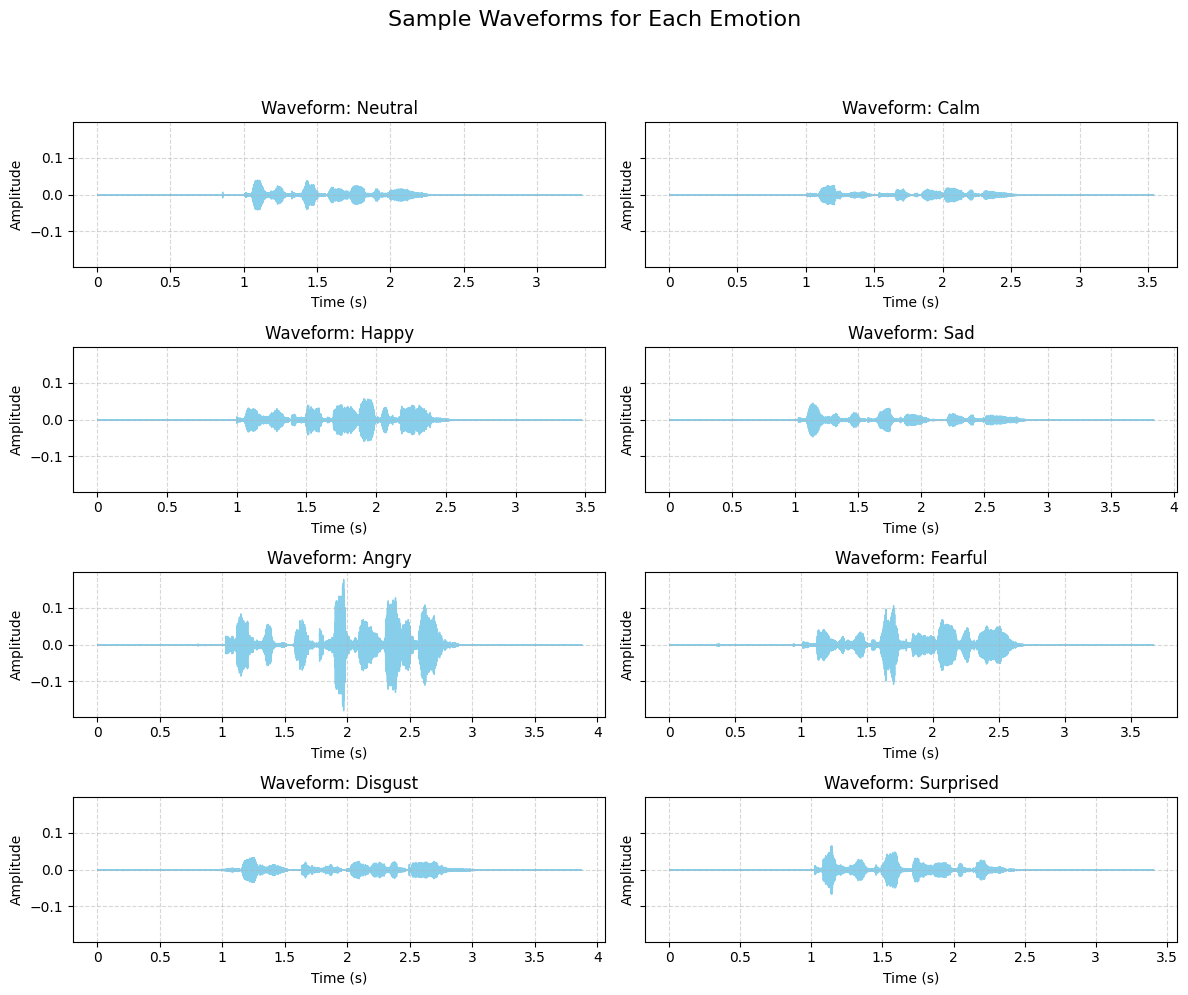

In [ ]:
# The following line creates a 4x2 subplot grid using matplotlib to display waveforms for each emotion, ensuring a structured visual layout for analysis as part of the Results and Discussion section of the project report.
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10), sharex=False, sharey=True)

# The below line flattens the 2D array of axes into a 1D array for easier indexing during plotting, simplifying the process of assigning each emotion's waveform to a specific subplot.
axes = axes.flatten()

# The following line initializes an empty dictionary to store file paths for one representative audio file per emotion, aiding in the visualization of audio data characteristics.
emotion_files = {}

# The below line creates an empty set to track which emotions have already been processed, ensuring only one sample per emotion is selected for waveform plotting.
processed_emotions_wave = set()

# The following line prints a message to indicate the start of the waveform generation process, providing feedback on the progress of data visualization preparation.
print("\nGenerating sample waveforms...")

# The below block of code iterates through sorted actor folders in the data directory to find representative audio files for each emotion, ensuring systematic data selection as described in the Methods section of the project report.
for actor_folder in sorted(os.listdir(data_dir)):

    # The following line constructs the full path to the current actor's folder, facilitating file access within the dataset structure.
    actor_path = os.path.join(data_dir, actor_folder)

    # The below line checks if the current path is a directory, ensuring only valid actor folders are processed.
    if os.path.isdir(actor_path):

        # The following line iterates through sorted file names in the actor's folder to locate audio files for emotion sampling.
        for file_name in sorted(os.listdir(actor_path)):

            # The below line checks if the file is a WAV audio file, filtering for relevant data files to process.
            if file_name.endswith('.wav'):
                try:

                    # The following line extracts the emotion code from the filename using a split operation, assuming a specific naming convention for RAVDESS dataset files.
                    emotion_code = file_name.split('-')[2]

                    # The below line verifies if the extracted emotion code exists in the predefined emotions dictionary, ensuring valid emotion mapping.
                    if emotion_code in emotions:

                        # The following line retrieves the emotion name corresponding to the emotion code, mapping numerical codes to human-readable labels.
                        emotion_name = emotions[emotion_code]

                        # The below line checks if the emotion has not yet been processed, ensuring only one sample per emotion is selected.
                        if emotion_name not in processed_emotions_wave:

                            # The following line stores the file path for the current emotion in the dictionary, associating each emotion with a specific audio file for visualization.
                            emotion_files[emotion_name] = os.path.join(actor_path, file_name)

                            # The below line adds the emotion name to the processed set, marking it as handled to avoid duplicates.
                            processed_emotions_wave.add(emotion_name)

                            # The following line prints a confirmation message when a sample for the current emotion is found, providing progress feedback.
                            print(f"  Found sample for {emotion_name}")

                            # The below line breaks the inner loop if all emotions have been processed, optimizing the search process.
                            if len(processed_emotions_wave) == len(emotions): break
                except Exception as e:

                    # The following line prints an error message if processing the file fails, ensuring transparency in data handling issues.
                    print(f"Error processing file {file_name} for waveform: {e}")

        # The below line breaks the outer loop if all emotions have been processed, further optimizing the search process.
        if len(processed_emotions_wave) == len(emotions): break

# The following line sorts the emotion files dictionary by emotion name based on a predefined list order, ensuring consistent plotting order for visual clarity in the report.
sorted_emotion_files = sorted(emotion_files.items(), key=lambda item: emotion_list.index(item[0]))

# The below block of code iterates through the sorted emotion files to plot waveforms for each emotion, contributing to the exploratory data analysis in the Results section of the project report.
for idx, (emotion_name, file_path) in enumerate(sorted_emotion_files):

    # The following line checks if the current index is within the range of available axes, preventing index errors during plotting.
    if idx < len(axes):

        # The below line assigns the current axis from the flattened array for plotting the waveform of the current emotion.
        ax = axes[idx]

        # The following line checks if the audio file exists at the specified path, ensuring data availability before processing.
        if os.path.exists(file_path):

            # The below line loads the audio file using librosa with a specified sampling rate, preparing the data for visualization.
            audio, sr = librosa.load(file_path, sr=22050)

            # The following line displays the waveform of the audio data on the current axis, using a specific color for visual distinction.
            librosa.display.waveshow(audio, sr=sr, ax=ax, color='skyblue')

            # The below line sets the title of the current subplot to indicate the emotion, aiding in identifying the visualized data.
            ax.set_title(f'Waveform: {emotion_name.capitalize()}')

            # The following line labels the x-axis as time in seconds, providing context for the waveform's temporal dimension.
            ax.set_xlabel('Time (s)')

            # The below line labels the y-axis as amplitude, indicating the intensity measure of the audio signal.
            ax.set_ylabel('Amplitude')

            # The following line adds a grid to the plot with a dashed style and transparency, enhancing readability of the waveform.
            ax.grid(True, linestyle='--', alpha=0.5)
        else:

            # The below line prints a message if the file is not found, documenting any issues with data availability.
            print(f"File {file_path} not found. Skipping waveform for {emotion_name}.")

            # The following line sets a title indicating the emotion and that the data is missing, maintaining plot structure despite data absence.
            ax.set_title(f'Waveform: {emotion_name.capitalize()} (Missing)')

            # The below line adds a text message in the center of the subplot to indicate the file is not found, providing a visual cue for missing data.
            ax.text(0.5, 0.5, 'File Not Found', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# The following block of code removes any unused subplots from the grid if fewer emotions are plotted than available axes, ensuring a clean visual presentation.
for i in range(len(sorted_emotion_files), len(axes)):

    # The below line deletes the unused axis from the figure, avoiding empty subplots in the final visualization.
    fig.delaxes(axes[i])

# The following line sets a super title for the entire figure, summarizing the purpose of the visualizations as sample waveforms for each emotion, aligning with the project's exploratory analysis goals.
plt.suptitle('Sample Waveforms for Each Emotion', fontsize=16, y=1.02)

# The below line adjusts the layout of the figure to prevent overlap of subplots and titles, ensuring readability in the final report output.
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# The following line (commented out) would save the figure as an image file, which could be included in the project report for documentation, though it is currently disabled.
# plt.savefig('all_emotion_waveforms_pytorch.png', bbox_inches='tight')

# The below line displays the final figure with all waveforms, fulfilling the requirement to present visual results as part of the project's deliverables.
plt.show()


In [ ]:
# The below line defines the file path where the trained model's state dictionary will be saved, adhering to the project requirement of submitting all relevant files for review.
model_save_path = 'speech_emotion_model_pytorch.pth'

# The following line saves the state dictionary of the trained CNN model for speech emotion recognition to the specified file path, ensuring the model's weights are preserved for future use or demonstration during job interviews.
torch.save(model.state_dict(), model_save_path)

# The below line prints a confirmation message indicating that the model's state dictionary has been successfully saved, providing transparency in the project deliverables as per the submission guidelines.
print(f"Model state dictionary saved to {model_save_path}")

# The following line imports the 'joblib' library, which is used for saving and loading Python objects like the LabelEncoder, supporting the project requirement to include all necessary components for reproducibility.
import joblib

# The below line specifies the file path for saving the LabelEncoder object, which is crucial for mapping emotion labels back to their original categories during predictions.
le_save_path = 'label_encoder.joblib'

# The following line saves the LabelEncoder object to the specified file path using joblib, ensuring that the encoding scheme used for training is available for future inference or project evaluation.
joblib.dump(le, le_save_path)

# The below line prints a confirmation message that the LabelEncoder has been saved, maintaining clear documentation of project components as required for the final submission.
print(f"Label encoder saved to {le_save_path}")


Model state dictionary saved to speech_emotion_model_pytorch.pth
Label encoder saved to label_encoder.joblib


## 8. Prediction on a Sample File

Define a function to predict the emotion from a single audio file using the trained model and label encoder. Demonstrate its usage with an example audio file.


In [ ]:
# The below line defines a function to predict emotion from an audio file using a PyTorch model
def predict_emotion_pytorch(file_path, model, label_encoder, device):

    # The below line checks if the model parameter is a string (path to saved model)
    if isinstance(model, str):

        # The following line creates a new model instance with predefined input shape and classes
        loaded_model = SER_CNN(input_shape=(1, 180), num_classes=8) # Replace with actual shape/classes

        # The below line loads saved model parameters from the specified path
        loaded_model.load_state_dict(torch.load(model, map_location=device))

        # The following line moves the model to the specified device (CPU or GPU)
        loaded_model.to(device)

    # The below line handles the case when model is already loaded
    else:
        loaded_model = model

    # The below line checks if label_encoder is a string (path to saved encoder)
    if isinstance(label_encoder, str):

        # The following line loads the label encoder from the specified path
        le = joblib.load(label_encoder)

    # The below line handles the case when label_encoder is already loaded
    else:
        le = label_encoder


    # The following line sets the model to evaluation mode for inference
    loaded_model.eval() # Set to evaluation mode

    # The below line extracts audio features from the input file
    features = extract_features(file_path)

    # The following line returns an error message if feature extraction fails
    if features is None:
        return "Error processing audio"

    # The below line converts extracted features to a PyTorch tensor and prepares it for the model
    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # (1, 1, num_features)

    # The following line disables gradient calculation for inference to save memory
    with torch.no_grad():

        # The below line runs the model on the features to get prediction outputs
        outputs = loaded_model(features_tensor)

        # The following line gets the index of the maximum value, which is the predicted class
        _, predicted_idx = torch.max(outputs.data, 1)

    # The below line converts the predicted index back to an emotion label
    predicted_label = le.inverse_transform(predicted_idx.cpu().numpy())[0]

    # The following line returns the predicted emotion label
    return predicted_label


# The below line sets the path to an audio file for testing
sample_file = '/content/test.wav'

# The following line checks if the specified audio file exists
if os.path.exists(sample_file):

    # The below line calls the prediction function with the audio file and gets the result
    predicted_emotion = predict_emotion_pytorch(sample_file, model, le, device)

    # The following line prints the predicted emotion for the audio file
    print(f"\nPredicted Emotion for '{os.path.basename(sample_file)}': {predicted_emotion}")

# The below line handles the case when the audio file doesn't exist
else:

    # The following line prints an error message when the file is not found
    print(f"\nSample file not found at {sample_file}. Cannot run prediction example.")
